# RNN Exercise

**TASK: IMPORT THE BASIC LIBRARIES YOU THINK YOU WILL USE**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Project Tasks

**TASK: Read in the data set "Frozen_Dessert_Production.csv" from the Data folder. Figure out how to set the date to a datetime index columns**

In [2]:
df = pd.read_csv('Frozen_Dessert_Production.csv', index_col='DATE')

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**Task: Change the column name to Production**

In [4]:
df.columns = ['Production']

In [5]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**TASK: Plot out the time series**

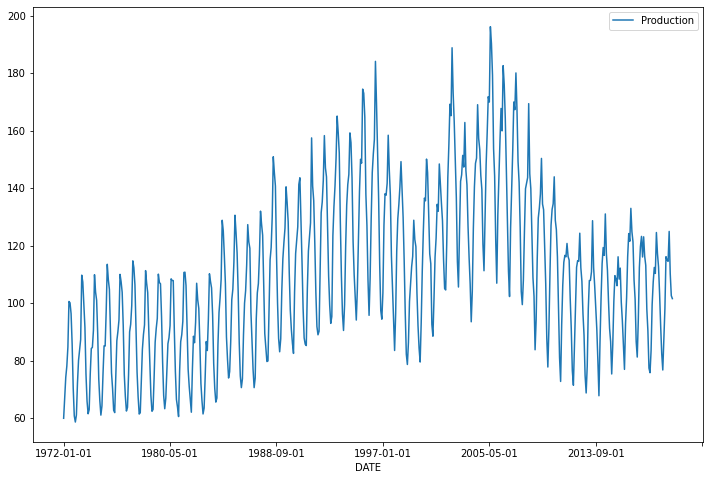

In [6]:
df.plot(figsize=(12,8))
plt.show()

## Train Test Split

**TASK: Figure out the length of the data set**

In [7]:
len(df)

573

**TASK: Split the data into a train/test split where the test set is the last 24 months of data.**

In [8]:
test_size = 24

In [9]:
train = df[:-test_size]
test = df[-test_size:]

In [10]:
len(test)

24

In [11]:
len(train)

549

## Scale Data

**TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [15]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [16]:
scaled_train.max()

1.0

# Time Series Generator

**TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The batch length is up to you, but at a minimum it should be at least 18 to capture a full year seasonality.**

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 18
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

### Create the Model

**TASK: Create a Keras Sequential Model with as many LSTM units you want and a final Dense Layer.**

In [19]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

In [20]:
# define model
model = Sequential()

model.add(LSTM(units=100, input_shape=(length, 1), activation='relu'))

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


**TASK: Create a generator for the scaled test/validation set. NOTE: Double check that your batch length makes sense for the size of the test set as mentioned in the RNN Time Series video.**

In [22]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

**TASK: Create an EarlyStopping callback based on val_loss.**

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

**TASK: Fit the model to the generator, let the EarlyStopping dictate the amount of epochs, so feel free to set the parameter high.**

In [25]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


531/531 [==============================] - 5s 7ms/step - loss: 0.0271 - val_loss: 0.0079
Epoch 2/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0124 - val_loss: 0.0012
Epoch 3/20
531/531 [==============================] - 3s 7ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 4/20
531/531 [==============================] - 3s 7ms/step - loss: 0.0041 - val_loss: 0.0018


**TASK: Plot the history of the loss that occured during training.**

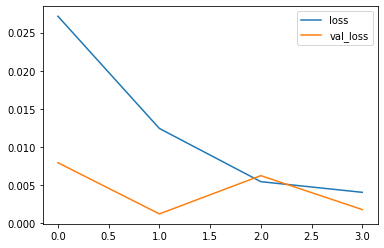

In [26]:
loss = pd.DataFrame(model.history.history)
loss.plot()
plt.show()

## Evaluate on Test Data

**TASK: Forecast predictions for your test data range (the last 12 months of the entire dataset). Remember to inverse your scaling transformations. Your final result should be a DataFrame with two columns, the true test values and the predictions.**

In [27]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

# loop for prediction
for i in range(len(test)):

  # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
  current_pred = model.predict(current_batch)[0]

  # store prediction
  test_predictions.append(current_pred)

  # update batch to now include prediction and drop first value
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

In [29]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,91.654582
2017-11-01,77.4378,86.127534
2017-12-01,75.8118,86.022441
2018-01-01,83.4343,93.019944
2018-02-01,99.4899,102.748699
2018-03-01,107.3152,111.474093
2018-04-01,112.4309,117.655311
2018-05-01,110.3544,120.727203
2018-06-01,124.5841,119.750988


**TASK: Plot your predictions versus the True test values. (Your plot may look different than ours).**

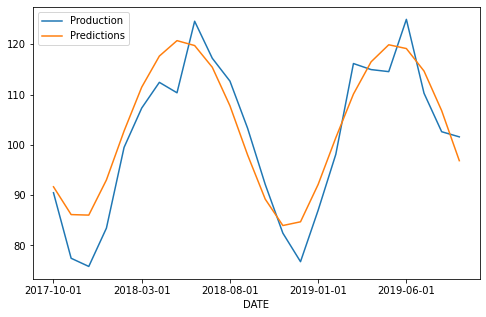

In [35]:
test.plot(figsize=(8,5))
plt.show()

**TASK: Calculate your RMSE.**

In [36]:
from sklearn.metrics import mean_squared_error

In [37]:
np.sqrt(mean_squared_error(test['Production'], test['Predictions']))

5.725148115217731

In [38]:
# model.save('first_frozen_dessert_production_model.h5')

## Trying improving these results

In [65]:
test_size = 18

train = df[:-test_size]
test = df[-test_size:]

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

length = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

# define model
model = Sequential()
model.add(LSTM(115, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

early_stop = EarlyStopping(monitor='val_loss',patience=3)

model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 115)               53820     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 116       
Total params: 53,936
Trainable params: 53,936
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


543/543 [==============================] - 4s 6ms/step - loss: 0.0245 - val_loss: 0.0031
Epoch 2/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0080 - val_loss: 0.0020
Epoch 3/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0056 - val_loss: 0.0083
Epoch 4/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 5/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0045 - val_loss: 0.0097
Epoch 6/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 7/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 8/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 9/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 10/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0029 - val_loss: 0.0029


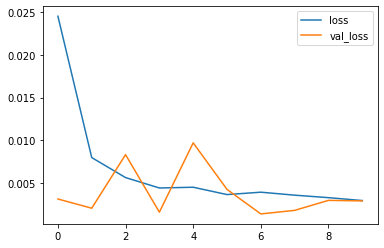

In [66]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [67]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [68]:
true_predictions = scaler.inverse_transform(test_predictions)

In [69]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
test

,Production,Predictions
DATE,,
2018-04-01,112.4309,119.092815
2018-05-01,110.3544,125.825398
2018-06-01,124.5841,128.422875
2018-07-01,117.2215,124.354849
2018-08-01,112.6779,114.554624
2018-09-01,103.3118,100.039935
2018-10-01,92.1321,86.969090
2018-11-01,82.4347,79.131813
2018-12-01,76.7608,79.890683


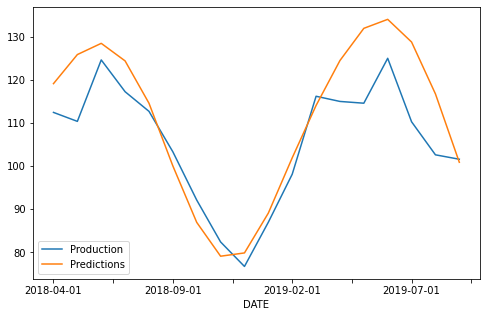

In [71]:
test.plot(figsize=(8,5))
plt.show()

In [72]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

8.964849912580068

Do not worth, have to do some modifications.